Redes Neuronales, Práctico 3

In [ ]:
from google.colab import drive
drive.mount ('/mnist')

Mounted at /mnist


Importamos las librerias necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn
from time import time
from google.colab import files

Cargamos el conjunto de datos de entrenamiento de mnist

In [ ]:
mnist_data = datasets.MNIST(',/data', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

Extracting ,/data/MNIST/raw/train-images-idx3-ubyte.gz to ,/data/MNIST/raw


Extracting ,/data/MNIST/raw/train-labels-idx1-ubyte.gz to ,/data/MNIST/raw



Extracting ,/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ,/data/MNIST/raw


Extracting ,/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ,/data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Observamos una imágen del conjunto de entrenamiento, a modo de ejemplo

5


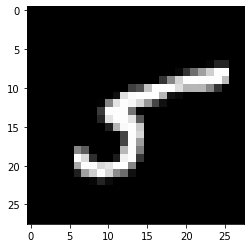

In [ ]:
plt.imshow(mnist_data[65][0].numpy().squeeze(), cmap='gray')
print(mnist_data[65][1])

Cargamos el conjunto de datos de test de mnist

In [ ]:
mnist_test = datasets.MNIST(',/data', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

Oservamos una imágen del conjunto de Test, a modo de ejemplo

In [ ]:
dataset_full = torch.utils.data.ConcatDataset([mnist_data,mnist_test])

In [ ]:
#new_train, new_test = torch.utils.data.random_split(dataset_full, [50000,20000])

In [ ]:
len(dataset_full)

70000

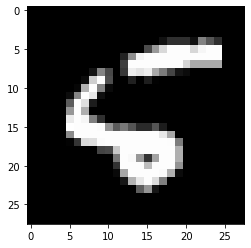

5


In [ ]:
plt.imshow(mnist_test[8][0].numpy().squeeze(), cmap='gray')
plt.show()
print(mnist_test[8][1])

Definimos los parámetros para el posterior entrenamiento de la red neuronal

In [ ]:
n_epochs         =    60
batch_size_train =   64
batch_size_test  = 1000
learning_rate    =    0.001
momentum         =    0.5
log_interval     =   10

random_seed = 1
torch.manual_seed(random_seed)

Generamos los Dataloaders de entrenamiento y test, los mismos son iteradores creados sobre el conjunto de datos de entrenamiento y test, que agrupan los datos en batch, mezclan los datos si es necesario, etc.

In [ ]:
train_loader1 = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_train, shuffle=True)
test_loader1  = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_test)

train_loader2 = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_train, shuffle=True)
test_loader2  = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_test)

train_loader3 = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_train, shuffle=True)
test_loader3  = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_test)

Definimos una operación que, dada una imagen, la "aplana", generandome un vector a partir de la imagen

In [ ]:
class Flatten(nn.Module):
  def forward(self, input):
      return input.view(input.size(0), -1)

Definimos la arquitectura de la red: en _init_ definimos las capas que se van a utilizar, y en forward aplicamos esas capas en el orden requerido

In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.linear1 = nn.Linear(784, 64)
    self.linear2 = nn.Linear(64, 784)
    self.relu    = nn.ReLU()
    self.flatten = Flatten()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    return x

Generamos un objeto (network) que es una red particular con la arquitectura definida en net, y definimos que algoritmo de optimización vamos a utilizar para entrenarla

In [ ]:
network1   = autoencoder()
optimizer1 = torch.optim.SGD(network1.parameters(), lr=2,
                      momentum=momentum)

network2   = autoencoder()
optimizer2 = torch.optim.SGD(network2.parameters(), lr=4,
                      momentum=momentum)

network3   = autoencoder()
optimizer3 = torch.optim.SGD(network3.parameters(), lr=6,
                      momentum=momentum)


In [ ]:
train_losses1  = []
train_counter1 = []
test_losses1   = []
test_counter1  = [i*len(train_loader1.dataset) for i in range(n_epochs + 1)]

train_losses2  = []
train_counter2 = []
test_losses2   = []
test_counter2  = [i*len(train_loader2.dataset) for i in range(n_epochs + 1)]

train_losses3  = []
train_counter3 = []
test_losses3   = []
test_counter3  = [i*len(train_loader3.dataset) for i in range(n_epochs + 1)]

Definimos una función de entrenamiento:

  1. Con network.train() le decimos a la red que lo que sigue es entrenamiento, y por tanto debe guardar y actualizar gradientes
  2. Definimos la funcion de costo, es decir, la funcion que queremos minimizar, en este caso una entropía cruzada
  3. Barremos el dataloader de entrenamiento, dentro del cual:
    - Eliminamos los gradientes del paso anterior
    - Corremos el modelo sobre el batch en el cual estamos
    - Calculamos la funcion de costo entre la salida y la etiqueta
    - Calculamos los gradientes
    - Realizamos un paso del optimizador
    - Imprimimos y guardamos el valor de la funcion de costo cada ciertos pasos

In [ ]:
flatten = Flatten()

In [ ]:
#def train1(epoch):
#  network1.train1()
#  crossent1 = nn.MSELoss()
#  for batch_idx, (data, target) in enumerate(train_loader1):
#    optimizer1.zero_grad()
#    output = network1(data)
#    loss1 = crossent1(output, flatten(data)) 
#    loss1.backward()
#    optimizer1.step()
#    if batch_idx % log_interval == 0:
#      print('Train Epoch1: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#          epoch, batch_idx * len(data), len(train_loader1.dataset),
#          100. * batch_idx / len(train_loader1), loss1.item1()))
#      train_losses1.append(loss.item())
#      train_counter1.append(
#          (batch_idx*64) + ((epoch-1)*len(train_loader1.dataset)))
#      
#def train2(epoch):
#  network2.train2()
#  crossent2 = nn.MSELoss()
#  for batch_idx, (data, target) in enumerate(train_loader2):
#    optimizer2.zero_grad()
#    output = network2(data)
#    loss2 = crossent2(output, flatten(data)) 
#    loss2.backward()
#    optimizer2.step()
#    if batch_idx % log_interval == 0:
#      print('Train Epoch2: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#          epoch, batch_idx * len(data), len(train_loader2.dataset),
#          100. * batch_idx / len(train_loader2), loss.item()))
#      train_losses2.append(loss.item())
#      train_counter2.append(
#          (batch_idx*64) + ((epoch-1)*len(train_loader2.dataset)))
#      
#def train3(epoch):
#  network3.train3()
#  crossent3 = nn.MSELoss()
#  for batch_idx, (data, target) in enumerate(train_loader3):
#    optimizer3.zero_grad()
#    output = network3(data)
#    loss3 = crossent3(output, flatten(data)) 
#    loss3.backward()
#    optimizer3.step()
#    if batch_idx % log_interval == 0:
#      print('Train Epoch3: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#          epoch, batch_idx * len(data), len(train_loader3.dataset),
#          100. * batch_idx / len(train_loader3), loss.item()))
#      train_losses3.append(loss.item())
#      train_counter3.append(
#          (batch_idx*64) + ((epoch-1)*len(train_loader3.dataset)))

In [ ]:
def train(epoch):
  network1.train()
  crossent1 = nn.MSELoss()
  for batch_idx, (data, target) in enumerate(train_loader1):
    optimizer1.zero_grad()
    output = network1(data)
    loss1 = crossent1(output, flatten(data)) 
    loss1.backward()
    optimizer1.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch1: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader1.dataset),
          100. * batch_idx / len(train_loader1), loss1.item()))
      train_losses1.append(loss1.item())
      train_counter1.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader1.dataset)))

  network2.train()
  crossent2 = nn.MSELoss()
  for batch_idx, (data, target) in enumerate(train_loader2):
    optimizer2.zero_grad()
    output = network2(data)
    loss2 = crossent2(output, flatten(data)) 
    loss2.backward()
    optimizer2.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch2: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader2.dataset),
          100. * batch_idx / len(train_loader2), loss2.item()))
      train_losses2.append(loss2.item())
      train_counter2.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader2.dataset)))

  network3.train()
  crossent3 = nn.MSELoss()
  for batch_idx, (data, target) in enumerate(train_loader3):
    optimizer3.zero_grad()
    output = network3(data)
    loss3 = crossent3(output, flatten(data)) 
    loss3.backward()
    optimizer3.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch3: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader3.dataset),
          100. * batch_idx / len(train_loader3), loss3.item()))
      train_losses3.append(loss3.item())
      train_counter3.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader3.dataset)))

Definimos una funcion de test o evaluacion, en la cual calculamos y mostramos los valores de las métricas sobre este conjunto

In [ ]:
#def test1():
#  crossent1 = nn.MSELoss()
#  network1.eval()
#  test_loss1 = 0
#  correct = 0
#  with torch.no_grad():
#    for data, target in test_loader1:
#      output = network1(data)
#      test_loss1 += crossent1(output, flatten(data)).item()
#      pred = output.data.max(1, keepdim=True) [1]
#      correct += pred.eq(target.data.view_as(pred)).sum()
#  test_loss1 /= len(test_loader1.dataset)
#  test_losses1.append(test_loss1)
#  print('\nTest set: Avg. loss1: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#      test_loss1, correct, len(test_loader1.dataset), 
#      100. * correct / len(test_loader1.dataset)))
#  
#def test2():
#  crossent2 = nn.MSELoss()
#  network2.eval()
#  test_loss2 = 0
#  correct = 0
#  with torch.no_grad():
#    for data, target in test_loader2:
#      output = network2(data)
#      test_loss2 += crossent2(output, flatten(data)).item()
#      pred = output.data.max(1, keepdim=True) [1]
#      correct += pred.eq(target.data.view_as(pred)).sum()
#  test_loss2 /= len(test_loader2.dataset)
#  test_losses2.append(test_loss2)
#  print('\nTest set: Avg. loss2: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#      test_loss2, correct, len(test_loader2.dataset), 
#      100. * correct / len(test_loader2.dataset)))
#  
#def test3():
#  crossent3 = nn.MSELoss()
#  network3.eval()
#  test_loss3 = 0
#  correct = 0
#  with torch.no_grad():
#    for data, target in test_loader3:
#      output = network3(data)
#      test_loss3 += crossent3(output, flatten(data)).item()
#      pred = output.data.max(1, keepdim=True) [1]
#      correct += pred.eq(target.data.view_as(pred)).sum()
#  test_loss3 /= len(test_loader3.dataset)
#  test_losses3.append(test_loss3)
#  print('\nTest set: Avg. loss3: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#      test_loss3, correct, len(test_loader3.dataset), 
#      100. * correct / len(test_loader3.dataset)))

In [ ]:
def test():
  crossent1 = nn.MSELoss()
  network1.eval()
  test_loss1 = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader1:
      output = network1(data)
      test_loss1 += crossent1(output, flatten(data)).item()
      pred = output.data.max(1, keepdim=True) [1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss1 /= len(test_loader1.dataset)
  test_losses1.append(test_loss1)
  print('\nTest set: Avg. loss1: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss1, correct, len(test_loader1.dataset), 
      100. * correct / len(test_loader1.dataset)))
  crossent2 = nn.MSELoss()
  network2.eval()
  test_loss2 = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader2:
      output = network2(data)
      test_loss2 += crossent2(output, flatten(data)).item()
      pred = output.data.max(1, keepdim=True) [1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss2 /= len(test_loader2.dataset)
  test_losses2.append(test_loss2)
  print('\nTest set: Avg. loss2: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss2, correct, len(test_loader2.dataset), 
      100. * correct / len(test_loader2.dataset)))
  crossent3 = nn.MSELoss()
  network3.eval()
  test_loss3 = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader3:
      output = network3(data)
      test_loss3 += crossent3(output, flatten(data)).item()
      pred = output.data.max(1, keepdim=True) [1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss3 /= len(test_loader3.dataset)
  test_losses3.append(test_loss3)
  print('\nTest set: Avg. loss3: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss3, correct, len(test_loader3.dataset), 
      100. * correct / len(test_loader3.dataset)))

Entrenamos y medimos el modelo sobre todas las epocas

In [ ]:
start_time = time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

elapsed_time = time() - start_time
print("Elapsed time: %.2f seconds." % elapsed_time)
elapsed_time = elapsed_time/60
print("Elapsed time: %.2f minutes." % elapsed_time)

Streaming output truncated to the last 5000 lines.
Train Epoch3: 43 [33280/60000 (55%)]	Loss: 0.476126
Train Epoch3: 43 [33920/60000 (57%)]	Loss: 0.478261
Train Epoch3: 43 [34560/60000 (58%)]	Loss: 0.470565
Train Epoch3: 43 [35200/60000 (59%)]	Loss: 0.477722
Train Epoch3: 43 [35840/60000 (60%)]	Loss: 0.478608
Train Epoch3: 43 [36480/60000 (61%)]	Loss: 0.506687
Train Epoch3: 43 [37120/60000 (62%)]	Loss: 0.489479
Train Epoch3: 43 [37760/60000 (63%)]	Loss: 0.484620
Train Epoch3: 43 [38400/60000 (64%)]	Loss: 0.463003
Train Epoch3: 43 [39040/60000 (65%)]	Loss: 0.480676
Train Epoch3: 43 [39680/60000 (66%)]	Loss: 0.516333
Train Epoch3: 43 [40320/60000 (67%)]	Loss: 0.513895
Train Epoch3: 43 [40960/60000 (68%)]	Loss: 0.501994
Train Epoch3: 43 [41600/60000 (69%)]	Loss: 0.520294
Train Epoch3: 43 [42240/60000 (70%)]	Loss: 0.489056
Train Epoch3: 43 [42880/60000 (71%)]	Loss: 0.474588
Train Epoch3: 43 [43520/60000 (72%)]	Loss: 0.458803
Train Epoch3: 43 [44160/60000 (74%)]	Loss: 0.483718
Train Epoch3:

Pasamos el modelo al modo de evaluación

In [ ]:
network1.eval()
network2.eval()
network3.eval()

autoencoder(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=784, bias=True)
  (relu): ReLU()
  (flatten): Flatten()
  (dropout): Dropout(p=0.1, inplace=False)
)

Comparamos la salida del modelo con la entrada

In [ ]:
len(train_losses1)
len(train_losses2)
len(train_losses3)

5640

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

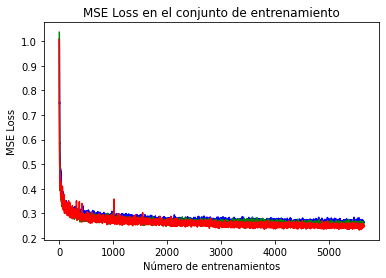

In [ ]:
nombre_imagen_loss = "{}Epocas_{}LR_{}Momentum_Loss_por_entrenamiento.png".format(n_epochs,learning_rate,momentum)
plt.xlabel("Número de entrenamientos")
plt.ylabel("MSE Loss")
plt.title("MSE Loss en el conjunto de entrenamiento")
plt.plot(train_losses1,color="blue")
plt.plot(train_losses2,color="green")
plt.plot(train_losses3,color="red")
plt.savefig(nombre_imagen_loss)
files.download(nombre_imagen_loss) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

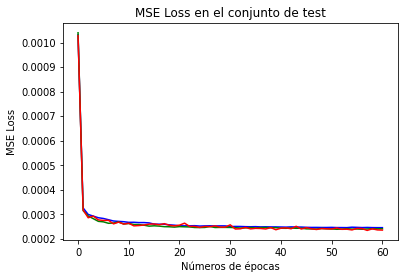

In [ ]:
nombre_imagen_loss = "{}Epocas_{}LR_{}Momentum_Loss_promedio_por_época.png".format(n_epochs,learning_rate,momentum)
plt.xlabel("Números de épocas")
plt.xticks(range(0,n_epochs+1,10))
plt.ylabel("MSE Loss")
plt.title("MSE Loss en el conjunto de test")
plt.plot(test_losses1,color="blue")
plt.plot(test_losses2,color="green")
plt.plot(test_losses3,color="red")
plt.savefig(nombre_imagen_loss)
files.download(nombre_imagen_loss) 

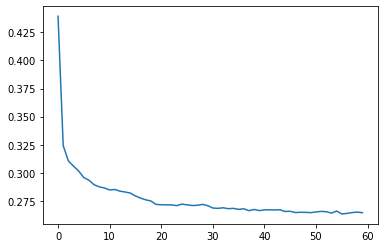

In [ ]:
plt.plot(np.array(train_losses1).reshape(epoch, len(train_losses2)//epoch).mean(axis=1))

In [ ]:
import pickle

with open("train_losses1.pickle", "wb") as f:
  pickle.dump(train_losses1, f)

files.download("train_losses1.pickle")

with open("test_losses1.pickle", "wb") as f:
  pickle.dump(test_losses1, f)

files.download("test_losses1.pickle")

with open("train_losses2.pickle", "wb") as f:
  pickle.dump(train_losses2, f)

files.download("train_losses2.pickle")

with open("test_losses2.pickle", "wb") as f:
  pickle.dump(test_losses2, f)

files.download("test_losses2.pickle")

with open("train_losses3.pickle", "wb") as f:
  pickle.dump(train_losses3, f)

files.download("train_losses3.pickle")

with open("test_losses3.pickle", "wb") as f:
  pickle.dump(test_losses3, f)

files.download("test_losses3.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#########------Elegir número del mnist a evaluar particularmente------#########

Numero_del_mnist1 = 4618
mnist_data[Numero_del_mnist1][1]

#########-------------------------------------------------------------#########

7

Comprovacion del autoencoder

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

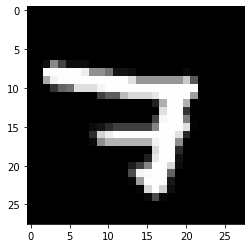

In [ ]:
## Imagen de entrada:

numero_imagen = mnist_test[Numero_del_mnist1][1]
Nombre_imagen = "Num{}_data{}_{}Epocas_{}LR_{}Momentum_Imagen_de_entrada.png".format(numero_imagen,Numero_del_mnist1,n_epochs,learning_rate,momentum)
Imagen_de_entrada = flatten(mnist_data[Numero_del_mnist1][0]).reshape([1,28,28]).squeeze()
plt.imshow(Imagen_de_entrada, cmap='gray')

new_data = np.zeros(np.array(Imagen_de_entrada.shape) * 10)
for j in range(Imagen_de_entrada.shape[0]):
    for k in range(Imagen_de_entrada.shape[1]):
        new_data[j * 10: (j+1) * 10, k * 10: (k+1) * 10] = Imagen_de_entrada[j, k]

Imagen_de_entrada = new_data

plt.imsave(Nombre_imagen,Imagen_de_entrada, cmap='gray')
files.download(Nombre_imagen) 

In [ ]:
## Imagen de Salida

numero_imagen = mnist_test[Numero_del_mnist1][1]
Nombre_imagen = "Num{}_data{}_{}Epocas_{}LR_{}Momentum_Imagen_de_salida.png".format(numero_imagen,Numero_del_mnist1,n_epochs,learning_rate,momentum)
Imagen_de_salida = network2(flatten(mnist_data[Numero_del_mnist1][0]).unsqueeze(0)).detach().numpy().reshape([1,28,28]).squeeze()
plt.imshow(Imagen_de_salida, cmap='gray')

new_data = np.zeros(np.array(Imagen_de_salida.shape) * 10)
for j in range(Imagen_de_salida.shape[0]):
    for k in range(Imagen_de_salida.shape[1]):
        new_data[j * 10: (j+1) * 10, k * 10: (k+1) * 10] = Imagen_de_salida[j, k]

Imagen_de_salida = new_data

plt.imsave(Nombre_imagen,Imagen_de_salida, cmap='gray')
files.download(Nombre_imagen) 

In [ ]:
#########------Elegir número del mnist a evaluar particularmente------#########

Numero_del_mnist = 5912
mnist_test[Numero_del_mnist][1]

#########-------------------------------------------------------------#########

In [ ]:
## Imagen de entrada:

numero_imagen = mnist_test[Numero_del_mnist][1]
Nombre_imagen = "Num{}_test{}_{}Epocas_{}LR_{}Momentum_Imagen_de_entrada.png".format(numero_imagen,Numero_del_mnist,n_epochs,learning_rate,momentum)
Imagen_de_entrada = flatten(mnist_test[Numero_del_mnist][0]).reshape([1,28,28]).squeeze()
plt.imshow(Imagen_de_entrada, cmap='gray')

new_data = np.zeros(np.array(Imagen_de_entrada.shape) * 10)
for j in range(Imagen_de_entrada.shape[0]):
    for k in range(Imagen_de_entrada.shape[1]):
        new_data[j * 10: (j+1) * 10, k * 10: (k+1) * 10] = Imagen_de_entrada[j, k]

Imagen_de_entrada = new_data

plt.imsave(Nombre_imagen,Imagen_de_entrada, cmap='gray')
files.download(Nombre_imagen) 

In [ ]:
## Imagen de Salida

numero_imagen = mnist_test[Numero_del_mnist][1]
Nombre_imagen = "Num{}_test{}_{}Epocas_{}LR_{}Momentum_Imagen_de_salida.png".format(numero_imagen,Numero_del_mnist,n_epochs,learning_rate,momentum)
Imagen_de_salida = network2(flatten(mnist_test[Numero_del_mnist][0]).unsqueeze(0)).detach().numpy().reshape([1,28,28]).squeeze()
plt.imshow(Imagen_de_salida, cmap='gray')

new_data = np.zeros(np.array(Imagen_de_salida.shape) * 10)
for j in range(Imagen_de_salida.shape[0]):
    for k in range(Imagen_de_salida.shape[1]):
        new_data[j * 10: (j+1) * 10, k * 10: (k+1) * 10] = Imagen_de_salida[j, k]

Imagen_de_salida = new_data

plt.imsave(Nombre_imagen,Imagen_de_salida, cmap='gray')
files.download(Nombre_imagen)

LO QUE SUIGUE LE COPIE A CRIS

In [ ]:
import pickle

In [ ]:
#########------Elegir modelo a evaluar particularmente------#########

n_epochs         =     60
learning_rate    =    0.1
momentum         =    0.5

In [ ]:
## Cargamos las loss
files.upload()

In [ ]:
#Cargar archivo a obj (cambiar obj por el nombre que queres)
Nombre_train_loss = "{}Epocas_{}LR_{}Momentum_train_losses.pickle".format(n_epochs,learning_rate,momentum)
with open(Nombre_train_loss, "rb") as f:
    train_losses = pickle.load(f)

Nombre_test_loss = "{}Epocas_{}LR_{}Momentum_test_losses.pickle".format(n_epochs,learning_rate,momentum)
with open(Nombre_test_loss, "rb") as f:
    test_losses = pickle.load(f)
#print(test_losses)